Requires running code from [`neighborhood_prediction`](./neighborhood_prediction/) first.

In [7]:
suppressPackageStartupMessages({
  library(cowplot)
  library(dplyr)
  library(dataorganizer)
  library(devtools)
  library(cellAdmix)
  library(ggplot2)

  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

theme_set(theme_bw())

ℹ Loading cellAdmixNotebooks


In [2]:
sc_obj <- load_scrnaseq_matrix_nsclc()

# log transform the data, since it's just approximately transcripts per thousand
scale_factor <- colSums(sc_obj[['RNA']]$counts)[1]
sc_obj[['RNA']]$data <- log1p((sc_obj[['RNA']]$counts*10000)/scale_factor) # to use same scale factor as seurat default

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 17.1 GiB”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”


In [3]:
### creating a version of the fractional counts with z-transform across cell types
frac_counts <- sc_obj[['RNA']]$counts / scale_factor
all_ct <- as.character(unique(sc_obj@meta.data$cell_type))
av_frac_counts <- lapply(all_ct,function(ct){
    cells_keep <- rownames(sc_obj@meta.data)[as.character(sc_obj@meta.data$cell_type)==ct]
    frac_counts_sub <- frac_counts[,cells_keep]
    av_frac_ct <- rowMeans(frac_counts_sub)
    return(av_frac_ct)
})
av_frac_counts_all_ct <- do.call(cbind,av_frac_counts)
av_frac_counts_scaled <- t(scale(t(av_frac_counts_all_ct)))
colnames(av_frac_counts_scaled) <- all_ct

# needs columns of 'gene', 'celltype', 'z'
g <- rep(rownames(av_frac_counts_scaled),ncol(av_frac_counts_scaled))
ct <- sapply(colnames(av_frac_counts_scaled),function(ct){
    return(rep(ct,nrow(av_frac_counts_scaled)))
})
ct <- c(ct)
z <- c(av_frac_counts_scaled)
ct_exp <- cbind.data.frame(g,ct,z)
colnames(ct_exp) <- c('gene','celltype','z')
ct_exp$celltype <- factor(ct_exp$celltype,levels=levels(sc_obj@meta.data$cell_type))
head(ct_exp)

,gene,celltype,z
,<chr>,<fct>,<dbl>
1,5S-rRNA,CD4+ T cells,-0.23194827
2,5-8S-rRNA,CD4+ T cells,-0.04040829
3,7SK,CD4+ T cells,-0.41558549
4,A1BG,CD4+ T cells,-0.39901089
5,A1BG-AS1,CD4+ T cells,-0.39967922
6,A1CF,CD4+ T cells,-0.34069447


In [5]:
# using expression of 'in' to predict presence of 'out'
# results precomputed in ./neighborhood_prediction/nb_pred_analysis_final.ipynb
np_res <- CachePath('nb_pred_2024_04_11_nsclc_in_neutrophil_out_tumor.csv') %>% read.csv()

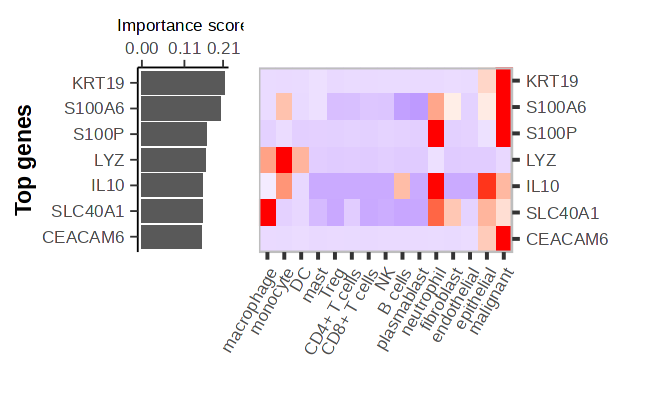

In [8]:
options(repr.plot.width = 3.25, repr.plot.height = 2, repr.plot.res = 200)
# options(repr.plot.width = 2.5, repr.plot.height = 1.5, repr.plot.res = 200)

gene_order <- rev(np_res$gene[1:7])

p_bar = np_res %>%
  filter(gene %in% gene_order) %>%
  mutate(gene = factor(gene, gene_order)) %>%
  ggplot(
    aes(x = importance_score, y = gene)
  ) +
  xlab('Importance score') +
  ylab('Top genes') +
  geom_col() +
  theme_classic(base_line_size = gg_line_thickness) +
  scale_x_continuous(breaks=round(seq(0, max(np_res$importance_score), max(np_res$importance_score)/2),digits = 2),position = "top") +
  p_theme +
  theme(
    axis.title.x = element_text(size=6),
    axis.title.y = element_text(size=8,face="bold")
  )

p_ct = ct_exp %>%
    filter(gene %in% gene_order) %>%
    mutate(gene = factor(gene, gene_order)) %>%
    ggplot(
        aes(x = celltype, y = gene, fill = z)
    ) +
    theme_classic() +
    geom_tile(show.legend = F) +
    scale_fill_gradient2(
        low = 'blue', mid = 'white',
        high = 'red',
        oob = scales::oob_squish,
        limits = c(-2, 2),
        na.value = 'whitesmoke'
    ) +
    scale_x_discrete(drop=FALSE, expand = expansion(add = 0), position = 'bottom') +
    scale_y_discrete(drop=FALSE, expand = expansion(add = 0), position = 'right') +
    p_theme +
    theme(
        axis.text.x = element_text(size = 6, angle = 60, vjust = 1, hjust = 1),
        axis.text.y = element_text(size = 6, hjust = 1, vjust = 0.5),
        panel.border = element_rect(fill = NA, color = 'gray'),
        axis.line = element_blank()
    ) +
    xlab('') + ylab('')

fig <- plot_grid(p_bar,p_ct,nrow=1,align = 'h',rel_widths = c(.3,.5))

fig

In [10]:
pdf(OutputPath("nsclc_nb_pred_neutro.pdf"), useDingbats=FALSE, width=3.25, height=2)
fig
dev.off()

png 
  2

In [11]:
np_res <- CachePath('nb_pred_2024_04_11_nsclc_in_macrophage_out_fibroblast.csv') %>% read.csv()

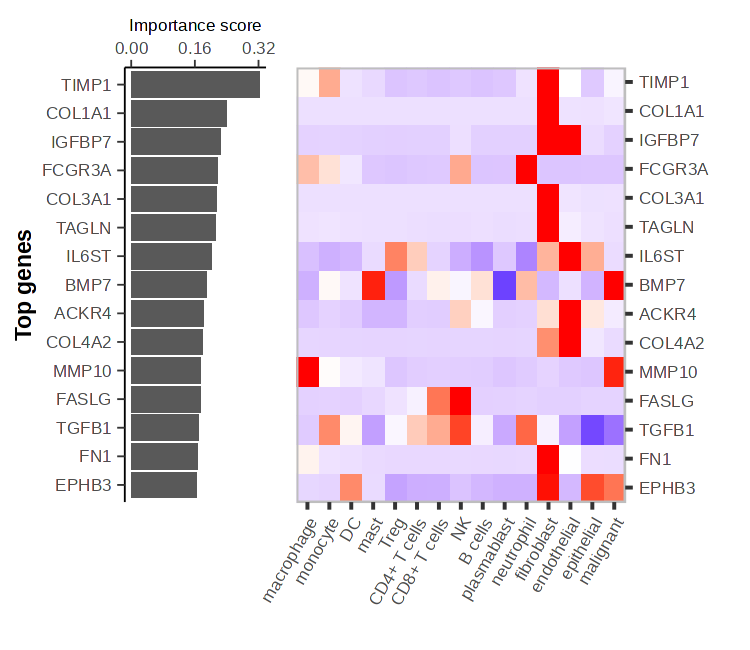

In [12]:
options(repr.plot.width = 3.75, repr.plot.height = 3.25, repr.plot.res = 200)
# options(repr.plot.width = 2.5, repr.plot.height = 1.5, repr.plot.res = 200)

gene_order <- rev(np_res$gene[1:15])

p_bar = np_res %>%
  filter(gene %in% gene_order) %>%
  mutate(gene = factor(gene, gene_order)) %>%
  ggplot(
    aes(x = importance_score, y = gene)
  ) +
  xlab('Importance score') +
  ylab('Top genes') +
  geom_col() +
  theme_classic(base_line_size = gg_line_thickness) +
  scale_x_continuous(breaks=round(seq(0, max(np_res$importance_score), max(np_res$importance_score)/2),digits = 2),position = "top") +
  p_theme +
  theme(
    axis.title.x = element_text(size=6),
    axis.title.y = element_text(size=8,face="bold")
  )

p_ct = ct_exp %>%
    filter(gene %in% gene_order) %>%
    mutate(gene = factor(gene, gene_order)) %>%
    ggplot(
        aes(x = celltype, y = gene, fill = z)
    ) +
    theme_classic() +
    geom_tile(show.legend = F) +
    scale_fill_gradient2(
        low = 'blue', mid = 'white',
        high = 'red',
        oob = scales::oob_squish,
        limits = c(-2, 2),
        na.value = 'whitesmoke'
    ) +
    scale_x_discrete(drop=FALSE, expand = expansion(add = 0), position = 'bottom') +
    scale_y_discrete(drop=FALSE, expand = expansion(add = 0), position = 'right') +
    p_theme +
    theme(
        axis.text.x = element_text(size = 6, angle = 60, vjust = 1, hjust = 1),
        axis.text.y = element_text(size = 6, hjust = 1, vjust = 0.5),
        panel.border = element_rect(fill = NA, color = 'gray'),
        axis.line = element_blank()
    ) +
    xlab('') + ylab('')

fig <- plot_grid(p_bar,p_ct,nrow=1,align = 'h',rel_widths = c(.3,.5))

fig

In [13]:
pdf(OutputPath("nsclc_nb_pred_macro.pdf"), useDingbats=FALSE, width=3.75, height=3.25)
fig
dev.off()

png 
  2